In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee, corner

Defining the model and likelihood functions

In [42]:
def compute_model(params, xarr):
    return np.poly1d(params)(xarr)

def log_prior(params):
    slope, cen = params
    if -3 < slope < 3 and 0 < cen < 100:
        return 0
    else:
        return -np.inf

def log_likelihood(params, xdata, ydata, ydata_err):
    lnpr = log_prior(params)
    if not np.isfinite(lnpr):
        return -np.inf
    
    ymodel = compute_model(params, xdata)
    log_like = -0.5 * np.sum((ydata - ymodel) ** 2 / (ydata_err ** 2) + np.log(2 * np.pi * ydata_err ** 2))

    return log_like

def make_all_plots(params, xdata, ydata, ydata_err):
    xarr = np.linspace(np.min(xdata), np.max(xdata), 10)
    ymodel_true = compute_model(params_true, xarr)
    ymodel = compute_model(params, xarr)

    fig, ax = plt.subplots(1)
    ax.errorbar(xdata, ydata, yerr=ydata_err, fmt='.', c='grey', capsize=0)
    ax.plot(xarr, ymodel_true, c='g', ls='--', label='params true', zorder=15)
    ax.plot(xarr, ymodel, c='r', ls='--', label='this params', zorder=20)
    ax.legend()

    return fig

Generating the fake data

In [43]:
params_true = [-1, 10]
ndata = 200
snr = 5
xdata = np.linspace(1, 50, ndata) + np.random.randn(ndata)
ydata = compute_model(params_true, xdata) + np.random.randn(ndata)
ydata_err = np.abs((ydata / snr) + np.random.randn(ndata))

Visualising the fake data

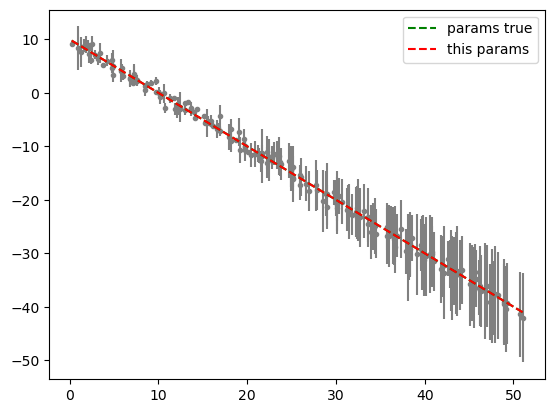

In [44]:
fig_true = make_all_plots(params_true, xdata, ydata, ydata_err)

Calling emcee fitting

In [46]:
ndim = len(params_true)
nwalkers = 32
niter = 5000

params_init = [2, 50]
labels = ['slope', 'cen']

In [47]:
pos = params_init + 1e-1 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(xdata, ydata, ydata_err))
dummy = sampler.run_mcmc(pos, niter, progress=True)

100%|██████████| 5000/5000 [00:06<00:00, 788.20it/s]


Visualising MCMC results

{'slope': -0.9617875758019606, 'cen': 9.447184953495956}


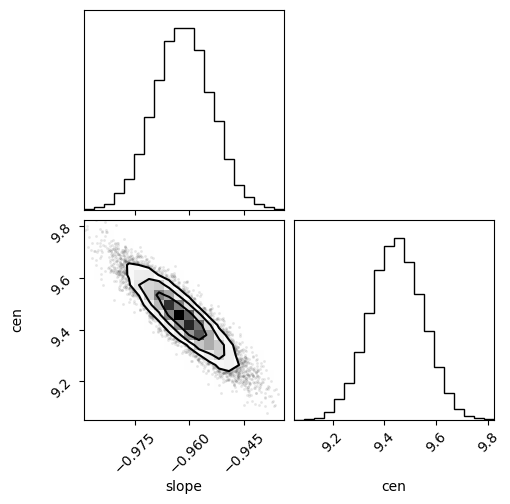

In [48]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig_corner = corner.corner(flat_samples, labels=labels, truths=params_true)

best_fit_params = [np.median(flat_samples[:, item]) for item in range(np.shape(flat_samples)[1])]
print(dict(zip(labels, best_fit_params)))

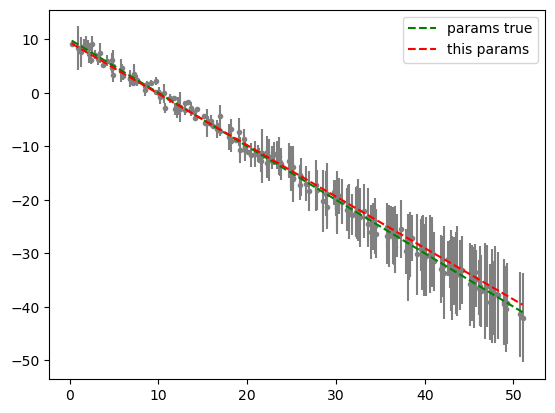

In [49]:
fig_mcmc = make_all_plots(best_fit_params, xdata, ydata, ydata_err)